<a href="https://colab.research.google.com/github/delhian/01_hak_9_03/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.set_option('display.float_format', lambda x: '%.10f' % x)
from sklearn.preprocessing import normalize
import numpy as np

from scipy.sparse import hstack, vstack

from sklearn.cluster import MiniBatchKMeans

from sklearn.preprocessing import LabelEncoder,OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb

from lightgbm import LGBMClassifier
from joblib import dump, load
import pickle

from sklearn.metrics import accuracy_score


from sklearn.model_selection import train_test_split

## Коллекционируем данные 

# train, test_2019, test_2020

In [ ]:
%%time
train = []
years = ['2015', '2016', '2017', '2018', '2019']

for year in years:
    tmp = pd.read_csv(f'./train/train_{year}.csv')
    tmp['year'] = year
    train.append (tmp)
del tmp
train = pd.concat(train)

# test 2019
test_2019 = []
years = ['2015', '2016', '2017', '2018']

for year in years:
    tmp = pd.read_csv(f'./test/test 2019/test_{year}.csv')
    tmp['year'] = year
    test_2019.append (tmp)
del tmp
test_2019 = pd.concat(test_2019)

# test 2020
test_2020 = []
years = ['2015', '2016', '2017', '2018', '2019']

for year in years:
    tmp = pd.read_csv(f'./test/test 2020/test_{year}.csv')
    tmp['year'] = year
    test_2020.append (tmp)
del tmp
test_2020 = pd.concat(test_2020)

CPU times: user 34.8 s, sys: 2.02 s, total: 36.8 s
Wall time: 19.9 s


In [ ]:
%%time

#  LabelEncoder :
le = LabelEncoder()
le.fit(np.append(train['CODE_CULTU'].unique(), test_2019['CODE_CULTU'].unique(),))

CPU times: user 692 ms, sys: 38.8 ms, total: 731 ms
Wall time: 475 ms


LabelEncoder()

In [ ]:
%%time

train['CODE_CULTU'] = le.transform(train['CODE_CULTU'])
test_2019['CODE_CULTU'] = le.transform(test_2019['CODE_CULTU'])
test_2020['CODE_CULTU'] = le.transform(test_2020['CODE_CULTU'])



train = train.pivot(index='centroid', columns='year', values=['CODE_CULTU','CODE_GROUP'])
train.columns = ['CODE_CULTU_'+ x for x in years] + ['CODE_GROUP_'+ x for x in years]
train.reset_index(inplace=True)

test_2019 = test_2019.pivot(index='centroid', columns='year', values=['CODE_CULTU','CODE_GROUP'])
test_2019.columns = ['CODE_CULTU_'+ x for x in years[:-1]] + ['CODE_GROUP_'+ x for x in years[:-1]]
test_2019.reset_index(inplace=True)

test_2020 = test_2020.pivot(index='centroid', columns='year', values=['CODE_CULTU','CODE_GROUP'])
test_2020.columns = ['CODE_CULTU_'+ x for x in years] + ['CODE_GROUP_'+ x for x in years]
test_2020.reset_index(inplace=True)

CPU times: user 36 s, sys: 3.7 s, total: 39.7 s
Wall time: 30.9 s


In [ ]:
train.columns, test_2019.columns, test_2020.columns

(Index(['centroid', 'CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
        'CODE_CULTU_2018', 'CODE_CULTU_2019', 'CODE_GROUP_2015',
        'CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',
        'CODE_GROUP_2019'],
       dtype='object'),
 Index(['centroid', 'CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
        'CODE_CULTU_2018', 'CODE_GROUP_2015', 'CODE_GROUP_2016',
        'CODE_GROUP_2017', 'CODE_GROUP_2018'],
       dtype='object'),
 Index(['centroid', 'CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
        'CODE_CULTU_2018', 'CODE_CULTU_2019', 'CODE_GROUP_2015',
        'CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',
        'CODE_GROUP_2019'],
       dtype='object'))

# centroid - > x, y (м)



In [ ]:
%%time
def centroid_x_y(df):
    df[['x', 'y']] = df['centroid'].str.split('[^\d\.]+', expand=True)[[1,2]]
    df['x'], df['y'] = df['x'].astype('float64'), df['y'].astype('float64')
    return df

train, test_2019, test_2020 = centroid_x_y(train), centroid_x_y(test_2019), centroid_x_y(test_2020)

CPU times: user 19.5 s, sys: 623 ms, total: 20.2 s
Wall time: 18 s


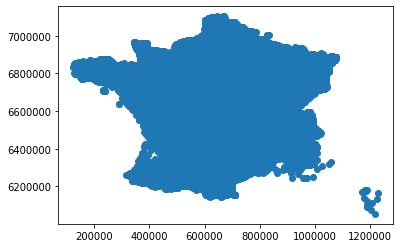

In [ ]:
# визуализируем 1% от centroid
unique_areas = train[['x', 'y']].drop_duplicates().sample(frac = 0.01)
plt.scatter(unique_areas['x'], unique_areas['y'], )

Видим почти полное заполнение территории Франции

Будем кластеризовать по координатам x, y + векторам из истории высадки культур.

![image.png](attachment:image.png)

![image.png](attachment:image.png)

## возьмем 64 по географии x,y: кластеров так, что средняя площадь кластера будет 10000 км^2 или квадрат со стороной 100 км

CPU times: user 38.1 s, sys: 542 ms, total: 38.6 s
Wall time: 37.5 s


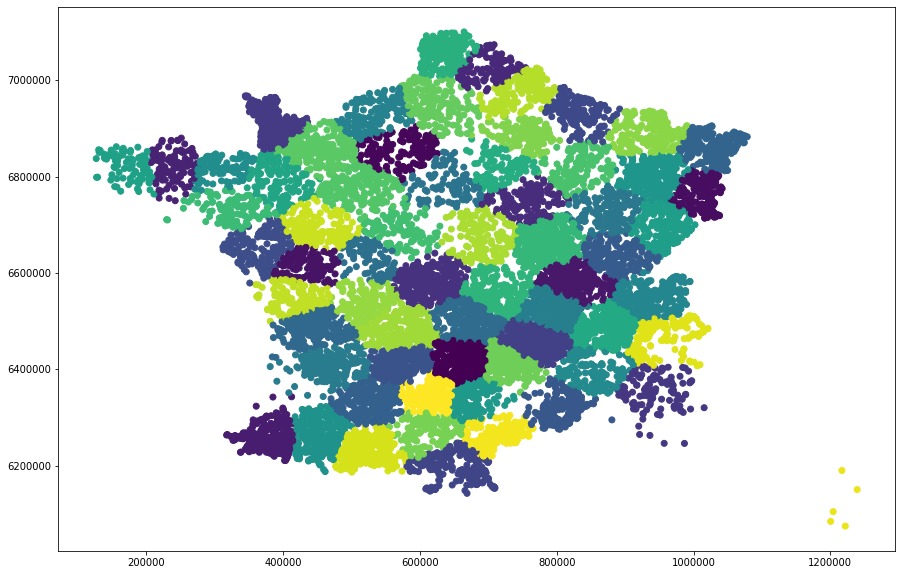

In [ ]:
%%time
# Кластеризуем:
n_clusters = 64
CLG = MiniBatchKMeans(n_clusters = n_clusters)
CLG.fit(train[['x', 'y']])
train['CLG'] = CLG.predict(train[['x', 'y']])


# визуализируем 1% от centroid
plt.figure(figsize =(15, 10))

unique_areas = train[train['CL'].isin(clusters)][['x', 'y', 'CLG']].sample(frac = 0.01)
color = unique_areas.CLG.astype(float)
plt.scatter(unique_areas['x'], unique_areas['y'], c=color, )

## Также добавим 64 кластера по векторам - истории посевов

In [ ]:
%%time
# векторизуем:
train['concat'] = ''
for y in ['CODE_CULTU_'+x for x in years]:
    train['concat'] += ' '
    train['concat'] += train[y].astype('str')

vect = TfidfVectorizer(lowercase = False, use_idf=False)
vect.fit(train['concat'].values)

X = vect.transform(train['concat'].values)
print(X.shape)

# Кластеризуем:
n_clusters = 64
CL = MiniBatchKMeans(n_clusters = n_clusters)
CL.fit(X)
train['CL'] = CL.predict(X)

(3614804, 302)
CPU times: user 1min 58s, sys: 12.1 s, total: 2min 10s
Wall time: 2min 10s


## Смотрим, как много культур включает каждый кластер 

In [ ]:
# 0.95 - персентиль:

PST = 0.95
clusters_distr = []
for cl in range(0, n_clusters ):
    tmp = pd.DataFrame(train[train ['CL'] == cl][['CODE_CULTU_'+x for x in years]].values.flatten())
    CNT = tmp.shape[0]
    tmp = pd.DataFrame(tmp[0].value_counts())
    tmp['cumsum'] = tmp[0].cumsum()
    CNT_CODE_CULTU = len(tmp[tmp['cumsum'] < CNT*0.95].index)+1
#     print(f'cl:{cl}, CNT_CODE_CULTU:{CNT_CODE_CULTU}, CNT: {CNT}')
    clusters_distr.append([cl, CNT_CODE_CULTU,CNT])
    
clusters_distr = pd.DataFrame(clusters_distr, columns = ['cl', 'CNT_CODE_CULTU', 'CNT'])

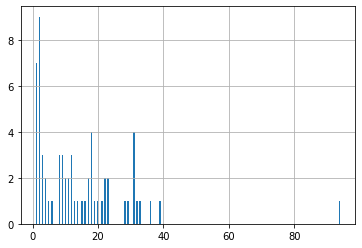

In [ ]:
clusters_distr.CNT_CODE_CULTU.hist(bins=200)

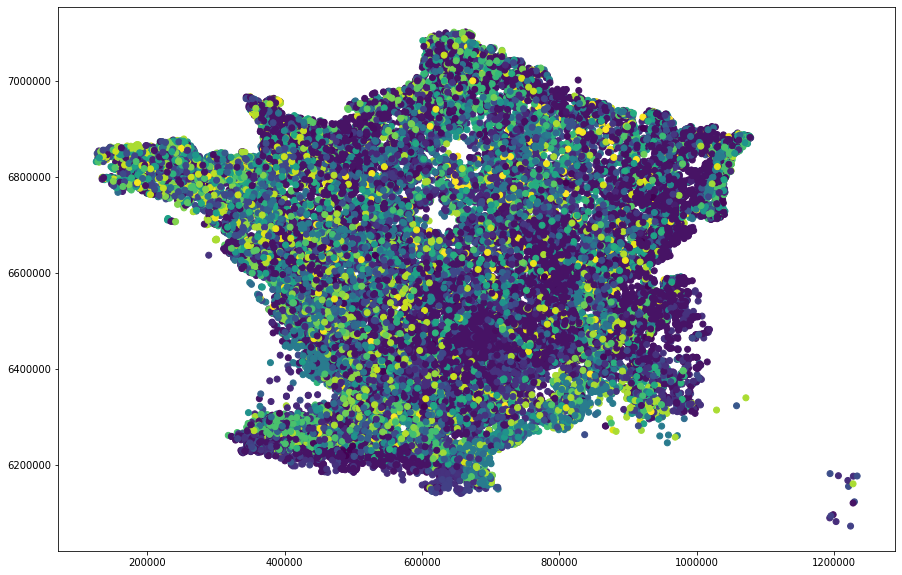

In [ ]:
# визуализируем 1% от centroid
unique_areas = train[['x', 'y', 'CL']].drop_duplicates().sample(frac = 0.01)
plt.figure(figsize =(15, 10))
plt.scatter(unique_areas['x'], unique_areas['y'], c=unique_areas.CL.astype(float))

## Видно, что кластеры по культурам не коррелируют с географичскими

## test_2019, test_2020 - предобработаем  тем же образом

In [ ]:
test_2019['concat'] = ''
for year in ['CODE_CULTU_'+x for x in years][:-1]:
    test_2019['concat'] += ' '
    test_2019['concat'] += test_2019[year].astype('str')
X = vect.transform(test_2019['concat'].values)
print(X.shape)

# Получаем номер кластера:
test_2019['CL'] = CL.predict(X)

(401645, 302)


In [ ]:
# ГЕОГРАФИЧЕСКИЕ КЛАСТЕРА :
test_2019['CLG'] = CLG.predict(test_2019[['x','y']])

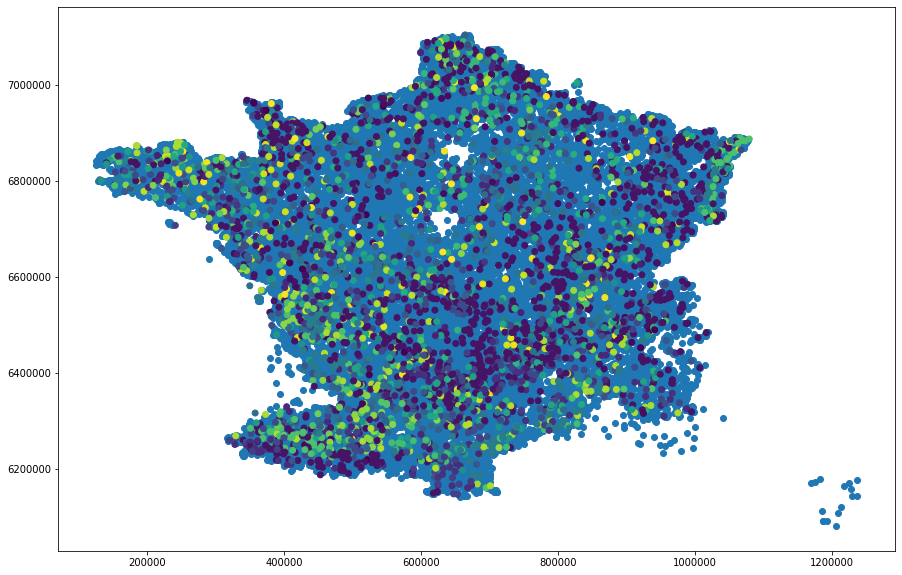

In [ ]:
# визуализируем 1% от centroid
unique_areas = train[['x', 'y', 'CL']].sample(frac = 0.01)
plt.figure(figsize =(15, 10))
plt.scatter(unique_areas['x'], unique_areas['y'],)
unique_areas = test_2019[['x', 'y', 'CL']].sample(frac = 0.01)
plt.scatter(unique_areas['x'], unique_areas['y'], c=unique_areas.CL.astype(float))

## видно, что centroid в test_2019 - взяты случайно из всех областей

In [ ]:
test_2020['concat'] = ''
for year in ['CODE_CULTU_'+x for x in years]:
    test_2020['concat'] += ' '
    test_2020['concat'] += test_2020[year].astype('str')
    
X = vect.transform(test_2020['concat'].values)
print(X.shape)

# Получаем номер кластера:
test_2020['CL'] = CL.predict(X)

(27, 302)


In [ ]:
# ГЕОГРАФИЧЕСКИЕ КЛАСТЕРА :
test_2020['CLG'] = CLG.predict(test_2020[['x','y']])

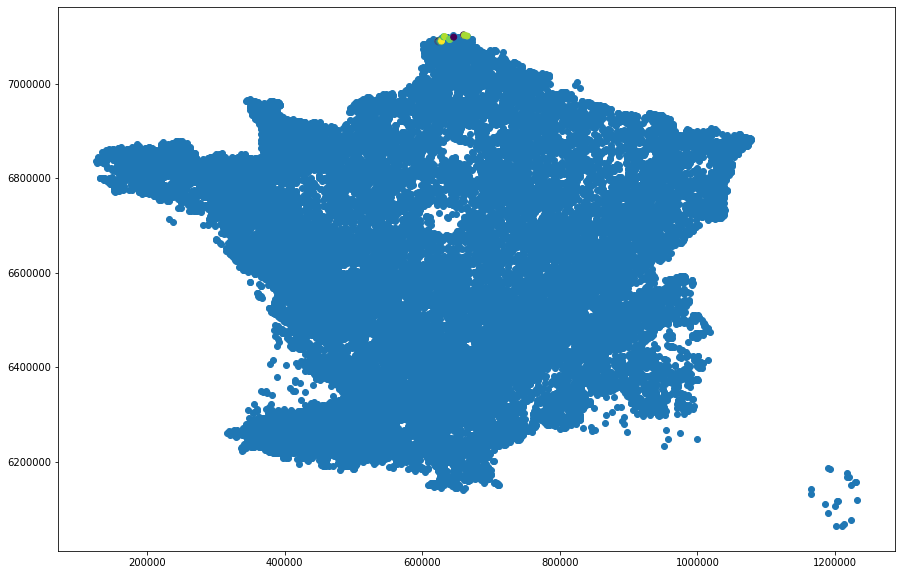

In [ ]:
# визуализируем 1% от centroid
unique_areas = train[['x', 'y', 'CL']].sample(frac = 0.01)
plt.figure(figsize =(15, 10))
plt.scatter(unique_areas['x'], unique_areas['y'],)

unique_areas = test_2020[['x', 'y', 'CL']]
plt.scatter(unique_areas['x'], unique_areas['y'], c=unique_areas.CL.astype(float))

In [ ]:
train.columns

Index(['centroid', 'CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
       'CODE_CULTU_2018', 'CODE_CULTU_2019', 'CODE_GROUP_2015',
       'CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',
       'CODE_GROUP_2019', 'x', 'y', 'concat', 'CL', 'CLG'],
      dtype='object')

In [ ]:
test_2019.columns

Index(['centroid', 'CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
       'CODE_CULTU_2018', 'CODE_GROUP_2015', 'CODE_GROUP_2016',
       'CODE_GROUP_2017', 'CODE_GROUP_2018', 'x', 'y', 'concat', 'CL', 'CLG'],
      dtype='object')

In [ ]:
test_2020.columns

Index(['centroid', 'CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
       'CODE_CULTU_2018', 'CODE_CULTU_2019', 'CODE_GROUP_2015',
       'CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',
       'CODE_GROUP_2019', 'x', 'y', 'concat', 'CL', 'CLG'],
      dtype='object')

In [ ]:
# save

with open('train.pickle', 'wb') as f:
    pickle.dump(train, f)
with open('test_2019.pickle', 'wb') as f:
    pickle.dump(test_2019, f)
with open('test_2020.pickle', 'wb') as f:
    pickle.dump(test_2020, f) 
with open('le.pickle', 'wb') as f:
    pickle.dump(le, f) 

## Классификация 

In [ ]:
# load
with open('train.pickle', 'rb') as f:
    train = pickle.load(f)
with open('test_2019.pickle', 'rb') as f:
    test_2019 = pickle.load(f)
with open('test_2020.pickle', 'rb') as f:
    test_2020 = pickle.load(f)
with open('le.pickle', 'rb') as f:
    le = pickle.load(f)

In [ ]:
def f_predict(train, cat_features_train, target_train, test, cat_features_test):
    test = test.copy()
    train = train.copy()
    train[cat_features] = train[cat_features].astype('category')
    test[cat_features] = test[cat_features].astype('category')


    for cl in test['CL'].sort_values().unique():
        print(f'cluster_n={cl}, ')
        train_condition, test_condition = train.CL == cl, test.CL == cl
        
        tr, y_tr = train[train_condition][cat_features_train], train[train_condition][[target_train]]
        tst = test[test_condition][cat_features_test]
        
        tr_classes= y_tr[target_train].unique()
        print(f'n- classes: {len(tr_classes)}')
        if len(tr_classes) == 2:
            lg = LGBMClassifier(objective = 'binary', learning_rate = 0.05, )
        else:
            lg = LGBMClassifier(objective = 'multiclass', learning_rate = 0.05, )
    #    если всего 1 класс в кластере:
        if len(tr_classes) == 1:
            predicted_tst = [tr_classes[0]] * len(y_tst)
            predicted_tr = [tr_classes[0]] * len(y_tr)
        else:
            lg.fit(tr, y_tr)
            predicted_tr = lg.predict(tr.values)
            predicted_tst = lg.predict(tst.values)
        print (f'tr_size={len(y_tr)}, accuracy_score={accuracy_score(predicted_tr, y_tr)}' )
        print (f'tst_size={len(y_tst)}')

        test.loc[test_condition, 'predicted'] = predicted_tst
    return test['predicted']    
#     return le.inverse_transform(test['predicted'].astype('int'))

In [ ]:
# _ = lgb.plot_importance(lg, figsize = (10, 7))

#  Валидация

 ## 1.  Обучаемся на '2015', '2016', '2017', '2018' из train, target '2019', 
  ## проверяем на test_2020

In [ ]:
cat_features_train = ['CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017', 'CODE_CULTU_2018',
                      'CODE_GROUP_2015','CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',
                      'CLG']
target_train = 'CODE_CULTU_2019'
cat_features_test = cat_features_train

test_2020['CODE_CULTU_2019_p'] = f_predict(train, cat_features_train, target_train, test_2020, cat_features_test)

cluster_n=5, 
n- classes: 114
tr_size=127529, accuracy_score=0.9489527872091837
tst_size=8218
cluster_n=20, 
n- classes: 141
tr_size=75539, accuracy_score=0.7350640066720502
tst_size=8218
cluster_n=28, 
n- classes: 111
tr_size=70113, accuracy_score=0.7806826123543423
tst_size=8218
cluster_n=43, 
n- classes: 213
tr_size=113750, accuracy_score=0.838276923076923
tst_size=8218
cluster_n=45, 
n- classes: 50
tr_size=86557, accuracy_score=0.9602805087976709
tst_size=8218
cluster_n=54, 
n- classes: 101
tr_size=7482, accuracy_score=0.7246725474472067
tst_size=8218
cluster_n=55, 
n- classes: 65
tr_size=42160, accuracy_score=0.9600332068311196
tst_size=8218
cluster_n=62, 
n- classes: 107
tr_size=30682, accuracy_score=0.7588488364513395
tst_size=8218


In [ ]:
accuracy_score(test_2020['CODE_CULTU_2019_p'], test_2020['CODE_CULTU_2019'])

0.8148148148148148

## 2.  Обучаемся на годах '2015', '2016', '2017', train, target => '2018', проверяем на test_2019

In [ ]:
%%time

cat_features_train = ['CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017',
                      'CODE_GROUP_2015','CODE_GROUP_2016', 'CODE_GROUP_2017',
                      'CLG']

target_train = 'CODE_CULTU_2018'
cat_features_test = cat_features_train

test_2019['CODE_CULTU_2018_p'] = f_predict(train, cat_features_train, target_train, test_2019, cat_features_test)

cluster_n=0, 
n- classes: 114
tr_size=41548, accuracy_score=0.8960479445460672
tst_size=8218
cluster_n=1, 
n- classes: 83
tr_size=18929, accuracy_score=0.7210100903375772
tst_size=8218
cluster_n=2, 
n- classes: 77
tr_size=191211, accuracy_score=0.9784688119407356
tst_size=8218
cluster_n=3, 
n- classes: 79
tr_size=56475, accuracy_score=0.8984329349269589
tst_size=8218
cluster_n=4, 
n- classes: 85
tr_size=69293, accuracy_score=0.8375449179570807
tst_size=8218
cluster_n=5, 
n- classes: 98
tr_size=127529, accuracy_score=0.9630358585106132
tst_size=8218
cluster_n=6, 
n- classes: 134
tr_size=107157, accuracy_score=0.9631195348880615
tst_size=8218
cluster_n=7, 
n- classes: 145
tr_size=45330, accuracy_score=0.7647253474520185
tst_size=8218
cluster_n=8, 
n- classes: 88
tr_size=30886, accuracy_score=0.8742796088842841
tst_size=8218
cluster_n=9, 
n- classes: 161
tr_size=149350, accuracy_score=0.8541680616002678
tst_size=8218
cluster_n=10, 
n- classes: 29
tr_size=68670, accuracy_score=0.9801368865

In [ ]:
accuracy_score(test_2019['CODE_CULTU_2018_p'], test_2019['CODE_CULTU_2018'])

0.8587882333901828

# predict

In [ ]:
accuracy_score(test_2020['CODE_CULTU_2019_p'], test_2020['CODE_CULTU_2019'])

0.8148148148148148

## test_2019: Делаем предсказания на 2019

In [ ]:
cat_features_train = ['CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017', 'CODE_CULTU_2018',
                      'CODE_GROUP_2015','CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',
                      'CLG']

cat_features_test = cat_features_train

target_train = 'CODE_CULTU_2019'

test_2019['CODE_CULTU_2019'] = f_predict(train, cat_features_train, target_train, test_2019, cat_features_test)

cluster_n=0, 
n- classes: 56
tr_size=15955, accuracy_score=0.9746787840802257
tst_size=8218
cluster_n=1, 
n- classes: 94
tr_size=12771, accuracy_score=0.6130295200062642
tst_size=8218
cluster_n=2, 
n- classes: 145
tr_size=91948, accuracy_score=0.738341236350981
tst_size=8218
cluster_n=3, 
n- classes: 3
tr_size=1059127, accuracy_score=0.9999830048709928
tst_size=8218
cluster_n=4, 
n- classes: 14
tr_size=12751, accuracy_score=0.9989020468982824
tst_size=8218
cluster_n=5, 
n- classes: 100
tr_size=15907, accuracy_score=0.8415791789778085
tst_size=8218
cluster_n=6, 
n- classes: 86
tr_size=52213, accuracy_score=0.903606381552487
tst_size=8218
cluster_n=7, 
n- classes: 116
tr_size=137538, accuracy_score=0.9448007096220681
tst_size=8218
cluster_n=8, 
n- classes: 25
tr_size=35740, accuracy_score=0.9672635702294348
tst_size=8218
cluster_n=9, 
n- classes: 37
tr_size=68519, accuracy_score=0.9824866095535545
tst_size=8218
cluster_n=10, 
n- classes: 106
tr_size=57573, accuracy_score=0.74995223455439

In [ ]:
codes = [x for x in test_2019.columns if 'CODE_CULTU' in x]
submission = test_2019[['centroid']+codes]

for col in codes:
    submission[col] = le.inverse_transform(test_2019[col].astype('int'))
submission

,centroid,CODE_CULTU_2015,CODE_CULTU_2016,CODE_CULTU_2017,CODE_CULTU_2018,CODE_CULTU_2019
0,Point (1000012.52413134 6375691.88737018),SPH,PPH,PPH,PPH,SPH
1,Point (1000016.53800574 6868298.13101281),MIE,BTH,MIE,BTH,MIS
2,Point (1000026.44207131 6886427.82606629),BTH,MIE,BTH,TTH,BTH
3,Point (1000034.22229768 6471767.45441523),PPH,PPH,PPH,PPH,PPH
4,Point (1000047.42389267 6799126.55615772),PPH,PPH,PPH,PPH,PPH
...,...,...,...,...,...,...
401640,Point (999950.84312505 6374505.43714411),PPH,PPH,PPH,PPH,PPH
401641,Point (999952.51974039 6740897.43259144),CZH,BTH,ORH,CZH,BTH
401642,Point (999958.07803688 6847044.97478564),PPH,PPH,PPH,PPH,PPH
401643,Point (999974.77922158 6471051.20153807),PPH,PPH,PPH,PPH,PPH


In [ ]:
submission[['centroid', 'CODE_CULTU_2019']].to_csv('predict2019.csv', index = False, header = False)

## test_2020: Делаем предсказания на 2020

In [ ]:
cat_features_train = ['CODE_CULTU_2015', 'CODE_CULTU_2016', 'CODE_CULTU_2017', 'CODE_CULTU_2018',
                      'CODE_GROUP_2015','CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018',
                      'CLG']

cat_features_test = ['CODE_CULTU_2016', 'CODE_CULTU_2017', 'CODE_CULTU_2018','CODE_CULTU_2019',
                      'CODE_GROUP_2016', 'CODE_GROUP_2017', 'CODE_GROUP_2018', 'CODE_GROUP_2019',
                      'CLG']

target_train = 'CODE_CULTU_2019'

test_2020['CODE_CULTU_2020'] = f_predict(train, cat_features_train, target_train, test_2020, cat_features_test)

cluster_n=2, 
n- classes: 145
tr_size=91948, accuracy_score=0.6795580110497238
tst_size=8218
cluster_n=7, 
n- classes: 116
tr_size=137538, accuracy_score=0.8360089575244659
tst_size=8218
cluster_n=19, 
n- classes: 47
tr_size=86220, accuracy_score=0.945627464625377
tst_size=8218
cluster_n=42, 
n- classes: 88
tr_size=29340, accuracy_score=0.4493183367416496
tst_size=8218
cluster_n=50, 
n- classes: 58
tr_size=15271, accuracy_score=0.26344050815270775
tst_size=8218
cluster_n=55, 
n- classes: 213
tr_size=103354, accuracy_score=0.06067496178183718
tst_size=8218
cluster_n=56, 
n- classes: 65
tr_size=41844, accuracy_score=0.16783768282190994
tst_size=8218
cluster_n=63, 
n- classes: 107
tr_size=13730, accuracy_score=0.3512745812090313
tst_size=8218


In [ ]:
codes = [x for x in test_2020.columns if 'CODE_CULTU' in x]
submission = test_2020[['centroid']+codes]

for col in codes:
    submission[col] = le.inverse_transform(test_2020[col].astype('int'))
submission

,centroid,CODE_CULTU_2015,CODE_CULTU_2016,CODE_CULTU_2017,CODE_CULTU_2018,CODE_CULTU_2019,CODE_CULTU_2020
0,Point (622928.74456392 7091374.91109849),BTA,BTA,BTA,BTA,BTA,BTA
1,Point (622967.31151578 7089473.09554707),BTA,BTA,BTA,BTA,BTA,BTA
2,Point (623112.8850607 7091321.76633075),BTH,PTC,BTH,LIF,BTH,LIF
3,Point (623199.71512481 7090404.68029447),BTA,BTA,BTA,BTA,BTA,BTA
4,Point (623252.64686805 7090535.58894731),BTH,AVP,CZH,BTH,PTC,BTH
5,Point (623254.31047299 7089357.24703729),BTA,BTA,BTA,BTA,BTA,BTA
6,Point (625771.91344838 7090455.27713006),BTH,BTN,BTH,PTC,BTH,BTN
7,Point (626681.19483355 7090558.39818072),BTA,BTA,BTA,BTA,BTA,BTA
8,Point (626872.73034846 7089630.58123009),BTA,BTA,BTA,BTA,BTA,BTA
9,Point (626890.49225881 7091695.38129481),BTA,BTA,BTA,BTA,BTA,BTA


In [ ]:
submission[['centroid', 'CODE_CULTU_2020']].to_csv('predict2020.csv', index = False, header = False)